In [1]:
# ! pip install seaborn

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import (
    GCNConv, GATv2Conv, SAGEConv, GINEConv,
    NNConv, PNAConv, global_mean_pool
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)


/home/pclab/miniconda3/envs/clam_latest/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/pclab/miniconda3/envs/clam_latest/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/pclab/miniconda3/envs/clam_latest/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/pclab/miniconda3/envs/clam_latest/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/pclab/miniconda3/envs/clam_latest/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'

# GNN Training on Histopathology Graphs (Delaunay)

This notebook trains GCN and GAT models on the graphs listed in `d_meta.csv`.

Pipeline:
1. Load metadata (`graph_path`, `label`).
2. Encode labels using a consistent mapping: Benign=0, InSitu=1, Invasive=2, Normal=3.
3. Load each `.pt` graph, attach its label (`data.y`).
4. Split into train/val/test (70/15/15 or configurable).
5. Define GCN and GAT architectures.
6. Train, validate, and test.
7. Report accuracy and classification report.
8. (Optional) Save best checkpoints.

Below cells implement this end-to-end.


Sample graphs per subtype:
  Benign: ['b023.pt', 'b013.pt']


/tmp/ipykernel_90601/3678054443.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


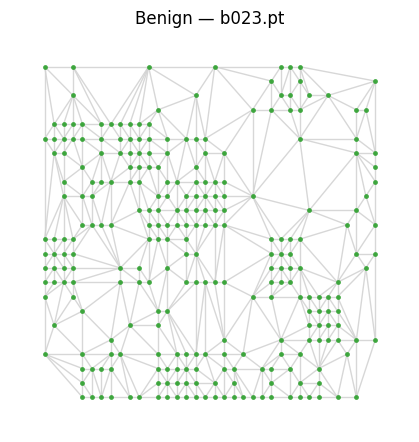

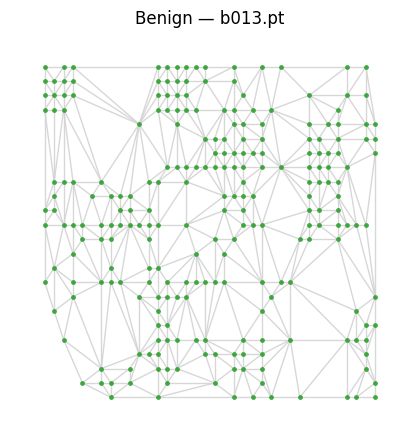

  InSitu: ['is089.pt', 'is082.pt']


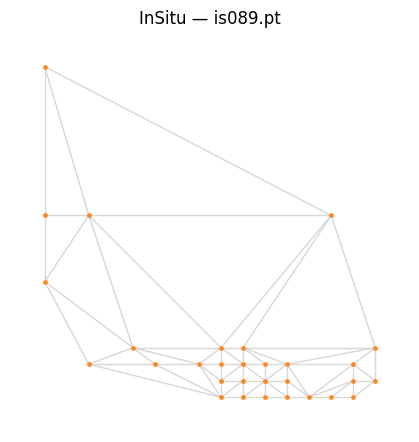

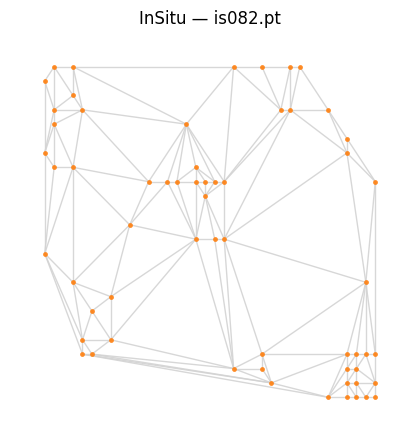

  Invasive: ['iv033.pt', 'iv004.pt']


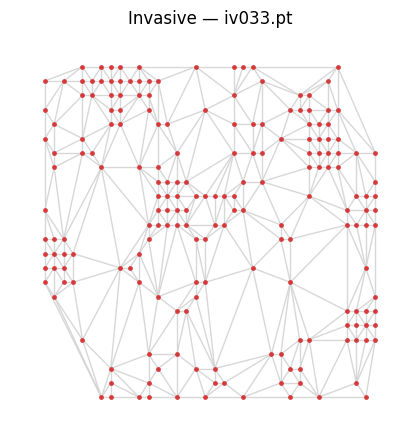

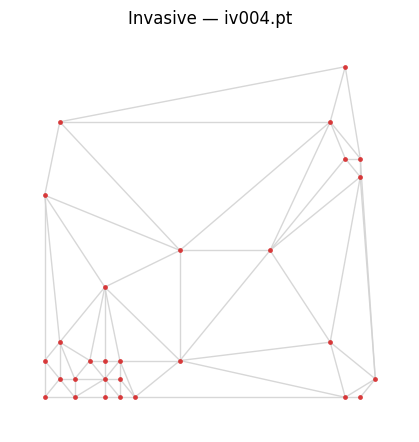

  Normal: ['n057.pt', 'n055.pt']


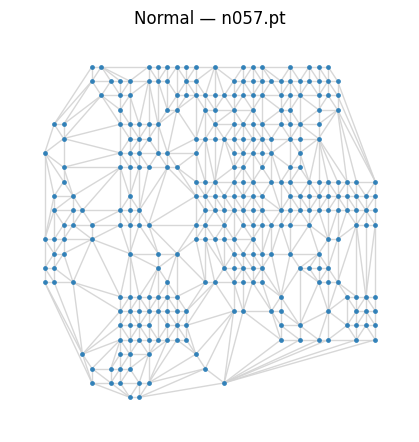

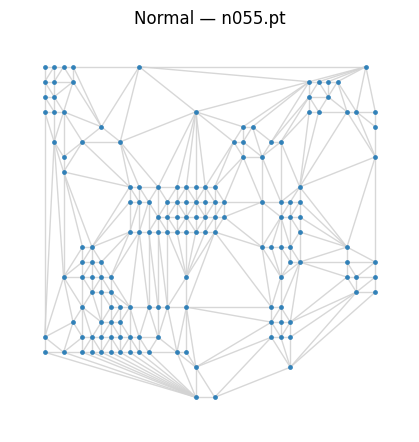

In [3]:
import torch
import pandas as pd
import random
from torch_geometric.data import DataLoader
from pathlib import Path
from torch_geometric.utils import to_networkx

# --- Configuration ---
metadata_path = 'datasets/d_meta.csv'  # must contain columns: graph_path,label
graph_dir = Path('datasets/graphs_delaunay')  # graph paths are relative in CSV
label_order = ['Benign', 'InSitu', 'Invasive', 'Normal']
label_to_int = {l:i for i,l in enumerate(label_order)}

metadata = pd.read_csv(metadata_path)
assert {'graph_path','label'}.issubset(metadata.columns), "d_meta.csv must have graph_path,label columns"

# Encode labels
metadata['y'] = metadata['label'].map(label_to_int)

# Filter out any rows with missing graph files
exists_mask = metadata['graph_path'].apply(lambda p: (graph_dir/p).is_file())
missing = metadata.loc[~exists_mask, 'graph_path'].tolist()
if missing:
    print(f"Warning: {len(missing)} graph files listed but not found. They will be skipped.")
    print(missing[:10])

metadata = metadata[exists_mask].reset_index(drop=True)

label_palette = {
    'Benign': 'tab:green',
    'InSitu': 'tab:orange',
    'Invasive': 'tab:red',
    'Normal': 'tab:blue'
}

def plot_graph_sample(rel_path, subtype):
    gpath = graph_dir / rel_path
    data = torch.load(gpath, weights_only=False)
    graph = to_networkx(data, to_undirected=True)
    layout = None
    if hasattr(data, "pos") and data.pos is not None:
        coords = data.pos.detach().cpu().numpy()
        layout = {idx: coords[idx] for idx in range(coords.shape[0])}
    plt.figure(figsize=(4, 4))
    nx.draw(
        graph,
        pos=layout,
        node_size=12,
        edge_color='lightgray',
        node_color=label_palette.get(subtype, 'tab:blue'),
        linewidths=0,
        alpha=0.9
    )
    plt.title(f"{subtype} — {rel_path}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

print("\nSample graphs per subtype:")
for label in label_order:
    candidates = metadata.loc[metadata['label'] == label, 'graph_path'].tolist()
    if not candidates:
        print(f"  {label}: none available")
        continue
    picks = random.sample(candidates, k=min(2, len(candidates)))
    print(f"  {label}: {picks}")
    for rel_path in picks:
        plot_graph_sample(rel_path, label)


In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool

class GCNNet(nn.Module):
    def __init__(self, in_dim, hidden=64, num_classes=4, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, num_classes)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        # x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class GATNet(nn.Module):
    def __init__(self, in_dim, hidden=32, heads=4, num_classes=4, dropout=0.3):
        super().__init__()
        self.gat1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout)
        self.gat2 = GATv2Conv(hidden*heads, hidden, heads=1, dropout=dropout)
        self.lin = nn.Linear(hidden, num_classes)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class CustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_laplacians=3):
        super().__init__(aggr='add')  # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.num_laplacians = num_laplacians

        # Learnable weights for Laplacian fusion
        self.alpha = nn.Parameter(torch.ones(num_laplacians) / num_laplacians)
        self.last_info = None

    def compute_symmetric_laplacian(self, edge_index, num_nodes):
        """Compute symmetric normalized Laplacian: L_sym = I - D^(-1/2) A D^(-1/2)"""
        row, col = edge_index
        deg = degree(col, num_nodes, dtype=torch.float)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Create sparse matrix for symmetric normalized adjacency
        adj_norm = torch.sparse_coo_tensor(
            edge_index, norm,
            (num_nodes, num_nodes)
        )

        # L_sym = I - D^(-1/2) A D^(-1/2)
        identity = torch.eye(num_nodes, device=adj_norm.device)
        laplacian = identity - adj_norm.to_dense()

        return laplacian

    def compute_combinatorial_laplacian(self, edge_index, num_nodes):
        """Compute combinatorial Laplacian: L_comb = D - A"""
        row, col = edge_index

        # Degree matrix
        deg = degree(col, num_nodes, dtype=torch.float)
        deg_mat = torch.diag(deg)

        # Adjacency matrix
        adj = torch.zeros(num_nodes, num_nodes, device=deg.device)
        adj[row, col] = 1.0

        # L_comb = D - A
        laplacian = deg_mat - adj

        return laplacian

    def compute_random_walk_laplacian(self, edge_index, num_nodes):
        """Compute random walk Laplacian: L_rw = I - D^(-1) A"""
        row, col = edge_index

        # Degree matrix and its inverse
        deg = degree(col, num_nodes, dtype=torch.float)
        deg_inv = deg.pow(-1)
        deg_inv[deg_inv == float('inf')] = 0
        deg_inv_mat = torch.diag(deg_inv)

        # Adjacency matrix
        adj = torch.zeros(num_nodes, num_nodes, device=deg.device)
        adj[row, col] = 1.0

        # L_rw = I - D^(-1) A
        identity = torch.eye(num_nodes, device=adj.device)
        laplacian = identity - torch.mm(deg_inv_mat, adj)

        return laplacian

    def forward(self, x, edge_index, capture_info=False):
        # Step 1: Add self-loops to the edge list
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linear transformation
        x_transformed = self.lin(x)

        # Step 3: Compute multiple Laplacians
        L1 = self.compute_symmetric_laplacian(edge_index, x.size(0))
        L2 = self.compute_combinatorial_laplacian(edge_index, x.size(0))
        L3 = self.compute_random_walk_laplacian(edge_index, x.size(0))

        # Apply softmax to ensure weights sum to 1 and are non-negative
        alpha_weights = F.softmax(self.alpha, dim=0)

        # Step 4: Fuse Laplacians
        L_fused = (alpha_weights[0] * L1 +
                   alpha_weights[1] * L2 +
                   alpha_weights[2] * L3)

        # Step 5: Convert to propagation matrix (I - L_fused)
        identity = torch.eye(x.size(0), device=L_fused.device)
        P_fused = identity - L_fused

        # Step 6: Perform propagation using matrix multiplication
        x_propagated = torch.mm(P_fused, x_transformed)

        if capture_info:
            self.last_info = {
                "alpha_weights": alpha_weights.detach().cpu(),
                "laplacians": {
                    "symmetric": L1.detach().cpu(),
                    "combinatorial": L2.detach().cpu(),
                    "random_walk": L3.detach().cpu(),
                },
                "L_fused": L_fused.detach().cpu(),
                "P_fused": P_fused.detach().cpu(),
            }
        else:
            self.last_info = None

        return x_propagated

    def message(self, x_j, norm):
        # This method is kept for interface compatibility but not used in the new approach
        return norm.view(-1, 1) * x_j


class GCNFusion(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        self.conv1 = CustomGCNConv(in_channels, hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data, return_info=False):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index, capture_info=return_info)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # x = self.conv2(x, edge_index)
        # x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        logits = self.lin(x)
        if return_info:
            return logits, self.conv1.last_info
        return logits

In [6]:
from sklearn.model_selection import train_test_split

graphs = []
for row in metadata.itertuples(index=False):
    g = torch.load(graph_dir / row.graph_path, map_location='cpu', weights_only=False)
    g.y = torch.tensor(int(row.y), dtype=torch.long)
    graphs.append(g)

indices = np.arange(len(graphs))
train_idx, temp_idx, y_train, y_temp = train_test_split(
    indices,
    metadata['y'].values,
    test_size=0.30,
    stratify=metadata['y'].values,
    random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

BATCH_SIZE = 16

train_dataset = [graphs[i] for i in train_idx]
val_dataset = [graphs[i] for i in val_idx]
test_dataset = [graphs[i] for i in test_idx]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test graphs.")

Loaded 261 train, 56 val, 57 test graphs.


/home/pclab/miniconda3/envs/clam_latest/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total += loss.item()
    return total / max(1, len(loader))


def eval_epoch(model, loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            p = out.argmax(dim=1)
            preds.extend(p.cpu().tolist())
            labels.extend(batch.y.cpu().tolist())
    acc = accuracy_score(labels, preds) if labels else 0.0
    return acc, preds, labels

In [8]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    return acc, all_preds, all_labels


In [9]:
# import time

# def run_models(train_loader, val_loader, test_loader, device=None, epochs=50, lr=1e-3):
#     device = device or (torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

#     sample = train_loader.dataset[0]
#     in_dim = sample.x.size(1)

#     models = {
#         'GCN': GCNNet(in_dim),
#         'GAT': GATNet(in_dim)
#     }

#     history = {}
#     best = {}

#     for name, model in models.items():
#         print(f"\n=== Training {name} ===")
#         model.to(device)
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#         criterion = nn.CrossEntropyLoss()
#         best_val = -1
#         best_state = None
#         start = time.time()
#         for epoch in range(1, epochs+1):
#             loss = train_epoch(model, train_loader, optimizer, criterion, device)
#             val_acc, _, _ = eval_epoch(model, val_loader, device)
#             if val_acc > best_val:
#                 best_val = val_acc
#                 best_state = model.state_dict()
#             if epoch % 10 == 0 or epoch == 1:
#                 print(f"Epoch {epoch:03d} | Loss {loss:.4f} | ValAcc {val_acc:.3f}")
#         elapsed = time.time()-start
#         model.load_state_dict(best_state)
#         test_acc, preds, labels = eval_epoch(model, test_loader, device)
#         report = classification_report(labels, preds, target_names=label_order, zero_division=0)
#         cm = confusion_matrix(labels, preds)
#         history[name] = {
#             'best_val_acc': best_val,
#             'test_acc': test_acc,
#             'report': report,
#             'confusion_matrix': cm,
#             'train_time_sec': round(elapsed,2)
#         }
#         print(f"{name} TestAcc {test_acc:.3f}")
#     return history

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# results = run_models(train_loader, val_loader, test_loader, device=device, epochs=50)
# for m, info in results.items():
#     print(f"\n--- {m} ---")
#     print(f"Best Val Acc: {info['best_val_acc']:.3f}  Test Acc: {info['test_acc']:.3f}")
#     print(info['report'])

In [10]:
import os, time, json
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix


def run_models(train_loader, val_loader, test_loader, device=None, epochs=50, lr=1e-3, save_dir="checkpoints"):
    device = device or (torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    os.makedirs(save_dir, exist_ok=True)

    sample = train_loader.dataset[0]
    in_dim = sample.x.size(1)
    print(f"Input feature dimension: {in_dim}")

    models = {
        'GCN': GCNNet(in_dim),
        'GAT': GATNet(in_dim),
        'GCN_Fusion': GCNFusion(in_dim, hidden_channels=64, out_channels=4, dropout=0.3)
    }

    history = {}

    for name, model in models.items():
        print(f"\n=== Training {name} ===")
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        best_val = -1.0
        best_state = None
        best_epoch = -1

        train_losses, train_accs, val_accs = [], [], []

        start = time.time()
        for epoch in range(1, epochs + 1):
            # Your train loop (returns avg loss over train set)
            loss = train_epoch(model, train_loader, optimizer, criterion, device)

            # Compute train/val accuracy using your eval_epoch
            train_acc, _, _ = eval_epoch(model, train_loader, device)
            val_acc,   _, _ = eval_epoch(model, val_loader,   device)

            train_losses.append(float(loss))
            train_accs.append(float(train_acc))
            val_accs.append(float(val_acc))

            if val_acc > best_val:
                best_val = float(val_acc)
                best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
                best_epoch = epoch

            if epoch % 5 == 0 or epoch == 1:
                print(f"[{name}] Epoch {epoch:03d} | TrainLoss {loss:.4f} | TrainAcc {train_acc:.3f} | ValAcc {val_acc:.3f}")

        elapsed = round(time.time() - start, 2)

        # Load best and evaluate on test
        model.load_state_dict(best_state)
        model.to(device)
        test_acc, preds, labels = eval_epoch(model, test_loader, device)

        # Save the best checkpoint separately per model
        ckpt_path = os.path.join(save_dir, f"{name}_best.pth")
        torch.save({
            "arch": name,
            "in_dim": in_dim,
            "state_dict": best_state,
            "best_val_acc": best_val,
            "best_epoch": best_epoch,
            "epochs_trained": epochs
        }, ckpt_path)
        print(f"[{name}] Saved best checkpoint -> {ckpt_path}")

        # Optional: also save training curves alongside the model
        curves_path = os.path.join(save_dir, f"{name}_history.json")
        with open(curves_path, "w") as f:
            json.dump({
                "train_loss_curve": train_losses,
                "train_acc_curve": train_accs,
                "val_acc_curve": val_accs,
                "best_epoch": best_epoch,
                "best_val_acc": best_val,
                "test_acc": float(test_acc),
                "train_time_sec": elapsed
            }, f, indent=2)
        print(f"[{name}] Wrote curves -> {curves_path}")

        if name == 'GCN_Fusion':
            model.eval()
            with torch.no_grad():
                sample_batch = next(iter(train_loader))
                sample_batch = sample_batch.to(device)
                _, lap_info = model(sample_batch, return_info=True)
            if lap_info is not None:
                alpha_str = ", ".join(f"{w.item():.4f}" for w in lap_info["alpha_weights"])
                print(f"[{name}] Laplacian Weights (softmax alpha): [{alpha_str}]")
                fused = lap_info["L_fused"]
                print(f"[{name}] Fused Laplacian shape: {tuple(fused.shape)}")
                print(f"[{name}] Fused Laplacian (top-left 5x5 block):\n{fused[:5, :5]}")
                for key, mat in lap_info["laplacians"].items():
                    print(f"[{name}] {key.replace('_', ' ').title()} Laplacian (top-left 5x5 block):\n{mat[:5, :5]}")
                if "P_fused" in lap_info:
                    print(f"[{name}] Propagation Matrix P (top-left 5x5 block):\n{lap_info['P_fused'][:5, :5]}")

        report = classification_report(labels, preds, target_names=label_order, zero_division=0)
        cm = confusion_matrix(labels, preds)

        history[name] = {
            'best_val_acc': best_val,
            'best_epoch': best_epoch,
            'final_train_loss': train_losses[-1],
            'final_train_acc': train_accs[-1],
            'test_acc': float(test_acc),
            'report': report,
            'confusion_matrix': cm,
            'train_loss_curve': train_losses,
            'train_acc_curve': train_accs,
            'val_acc_curve': val_accs,
            'train_time_sec': elapsed,
            'checkpoint_path': ckpt_path
        }

        print(f"{name} | Best Val Acc {best_val:.3f} @ epoch {best_epoch} | Test Acc {test_acc:.3f}")

    return history


# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
results = run_models(train_loader, val_loader, test_loader, device=device, epochs=50, lr=1e-3, save_dir="checkpoints")

for m, info in results.items():
    print(f"\n--- {m} ---")
    print(f"Best Val Acc: {info['best_val_acc']:.3f}  (epoch {info['best_epoch']})")
    print(f"Final Train Loss: {info['final_train_loss']:.4f}  Final Train Acc: {info['final_train_acc']:.3f}")
    print(f"Test Acc: {info['test_acc']:.3f}")
    print(info['report'])


Input feature dimension: 768

=== Training GCN ===
[GCN] Epoch 001 | TrainLoss 1.1589 | TrainAcc 0.831 | ValAcc 0.732
[GCN] Epoch 005 | TrainLoss 0.1655 | TrainAcc 0.992 | ValAcc 0.911


[GCN] Epoch 010 | TrainLoss 0.0460 | TrainAcc 1.000 | ValAcc 0.911
[GCN] Epoch 015 | TrainLoss 0.0203 | TrainAcc 1.000 | ValAcc 0.946
[GCN] Epoch 020 | TrainLoss 0.0093 | TrainAcc 1.000 | ValAcc 0.946
[GCN] Epoch 025 | TrainLoss 0.0056 | TrainAcc 1.000 | ValAcc 0.964
[GCN] Epoch 030 | TrainLoss 0.0043 | TrainAcc 1.000 | ValAcc 0.964
[GCN] Epoch 035 | TrainLoss 0.0035 | TrainAcc 1.000 | ValAcc 0.964
[GCN] Epoch 040 | TrainLoss 0.0025 | TrainAcc 1.000 | ValAcc 0.964
[GCN] Epoch 045 | TrainLoss 0.0019 | TrainAcc 1.000 | ValAcc 0.964
[GCN] Epoch 050 | TrainLoss 0.0016 | TrainAcc 1.000 | ValAcc 0.964
[GCN] Saved best checkpoint -> checkpoints/GCN_best.pth
[GCN] Wrote curves -> checkpoints/GCN_history.json
GCN | Best Val Acc 0.964 @ epoch 11 | Test Acc 0.930

=== Training GAT ===
[GAT] Epoch 001 | TrainLoss 0.9685 | TrainAcc 0.866 | ValAcc 0.786
[GAT] Epoch 005 | TrainLoss 0.0616 | TrainAcc 0.996 | ValAcc 0.893
[GAT] Epoch 010 | TrainLoss 0.0077 | TrainAcc 1.000 | ValAcc 0.946
[GAT] Epoch 01

In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plot_conf_mats(results):
#     for name, info in results.items():
#         cm = info['confusion_matrix']
#         plt.figure(figsize=(4,4))
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_order, yticklabels=label_order)
#         plt.title(f'{name} Confusion Matrix')
#         plt.ylabel('True')
#         plt.xlabel('Pred')
#         plt.tight_layout()
#         plt.show()

# plot_conf_mats(results)

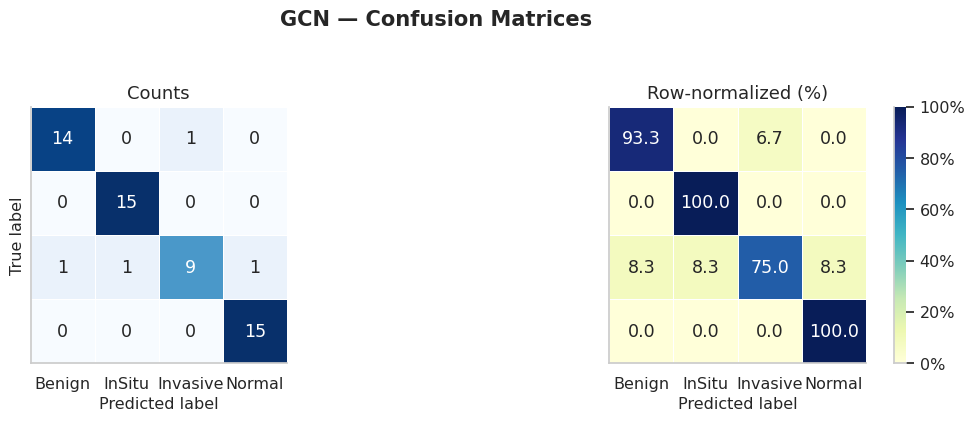

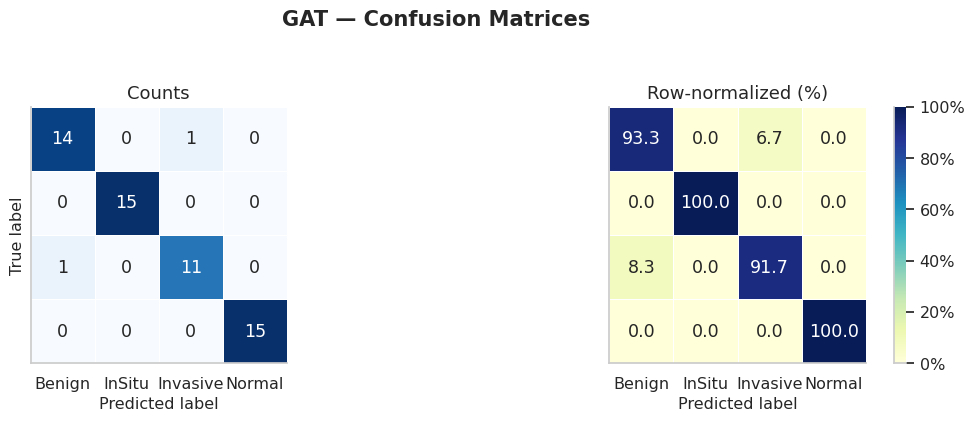

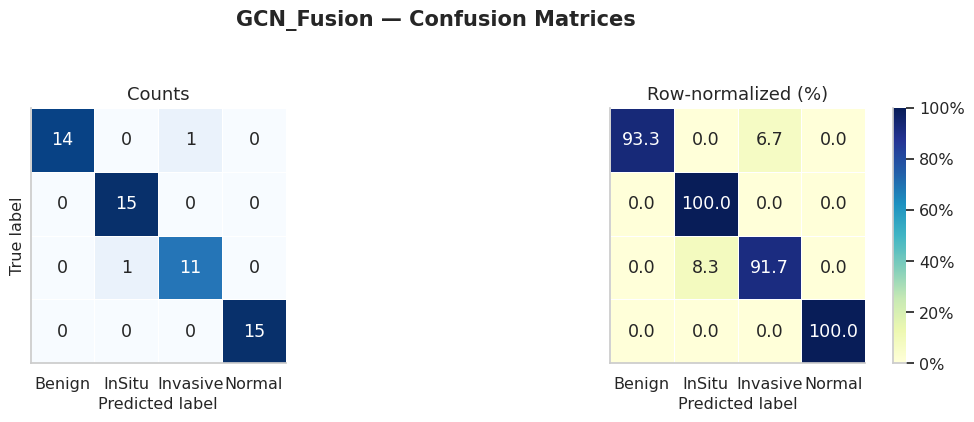

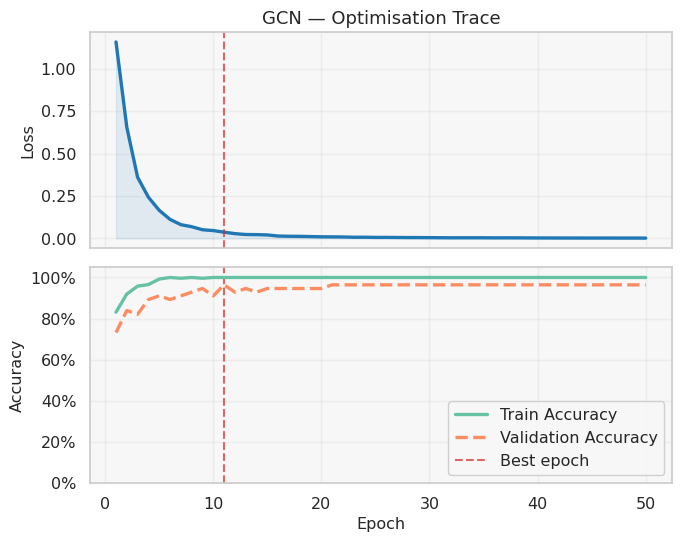

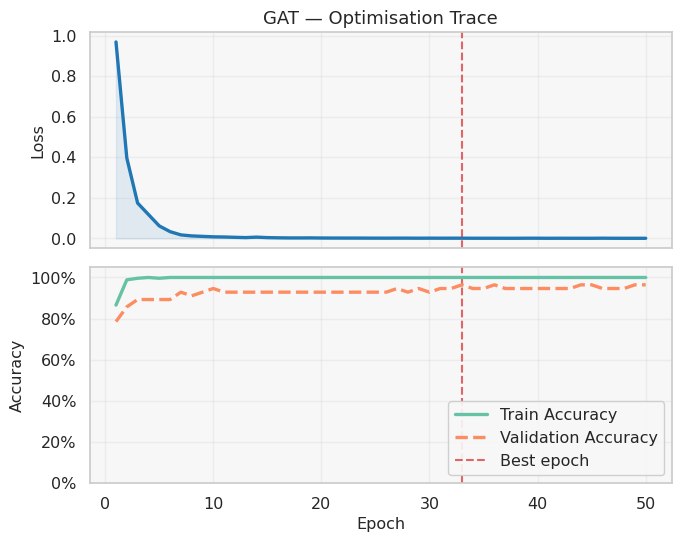

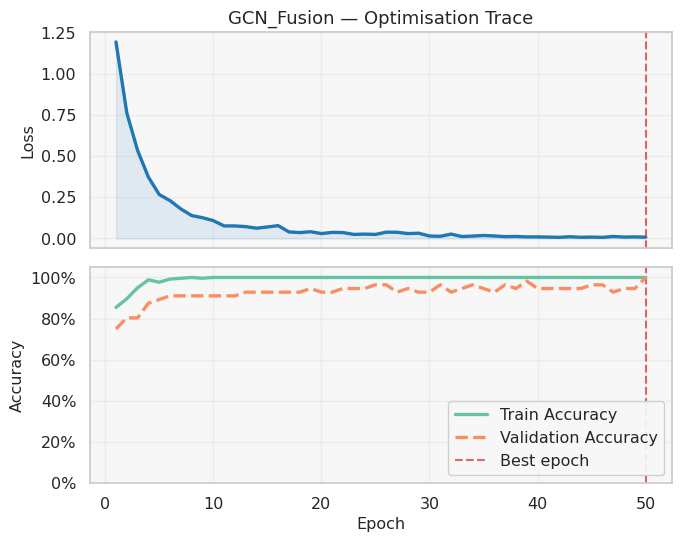

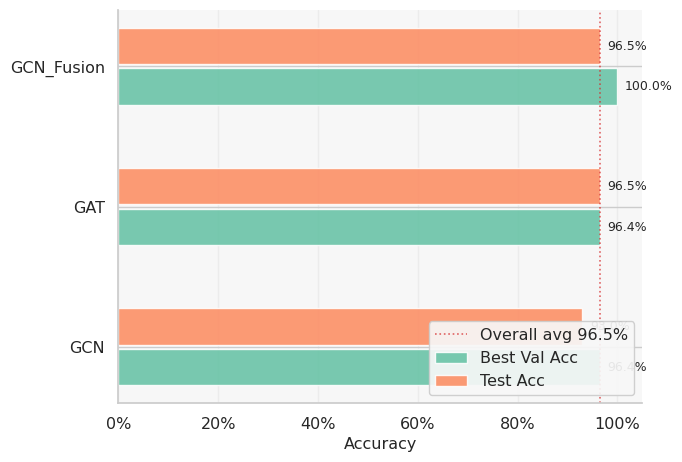

/tmp/ipykernel_90601/3203103751.py:360: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


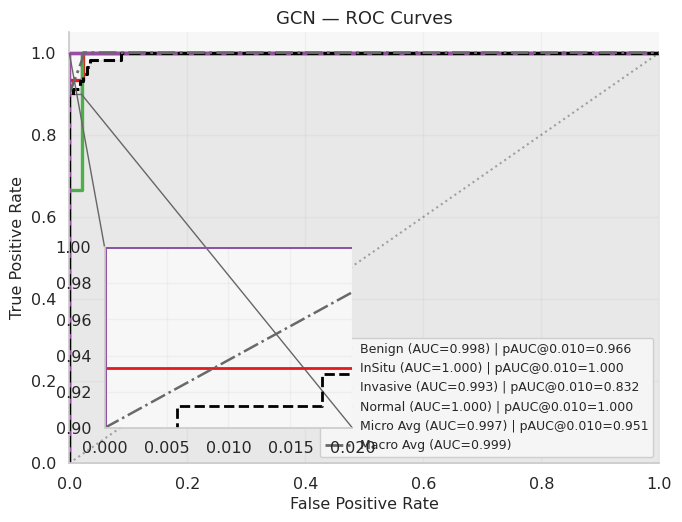

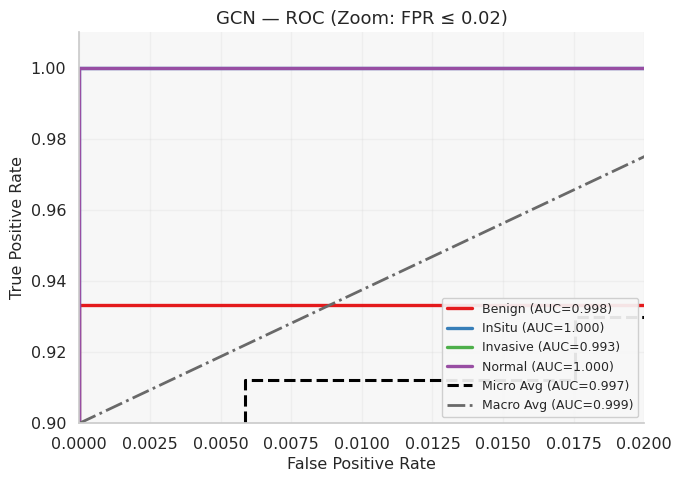

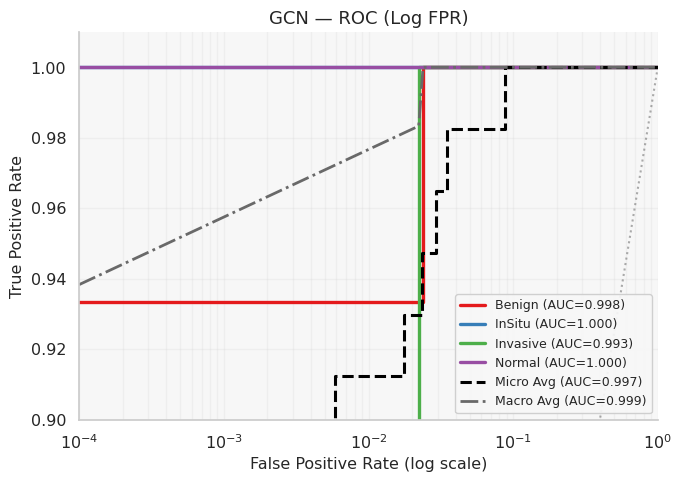

/tmp/ipykernel_90601/3203103751.py:360: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


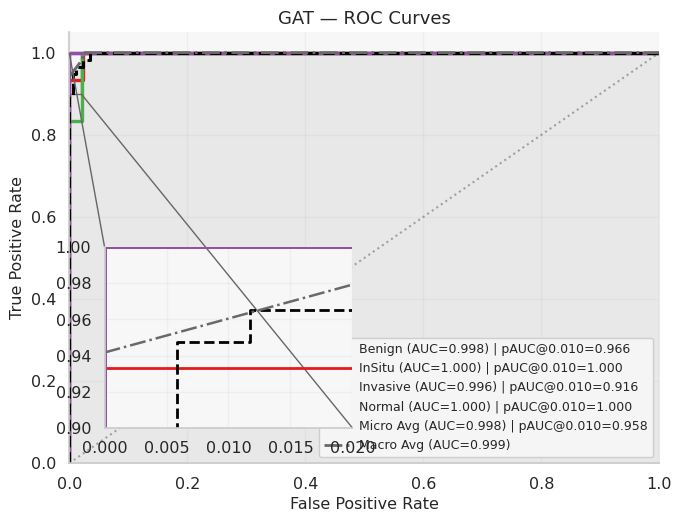

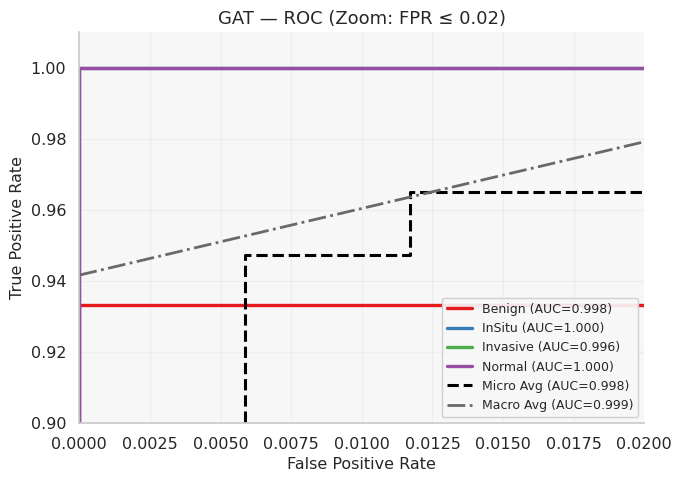

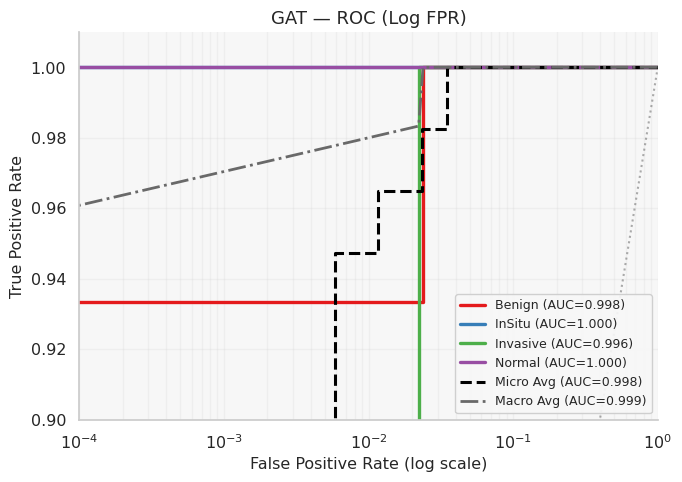

/tmp/ipykernel_90601/3203103751.py:360: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


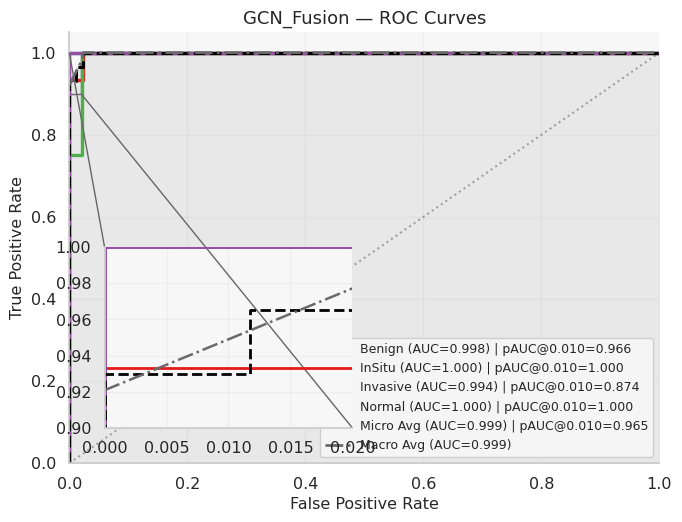

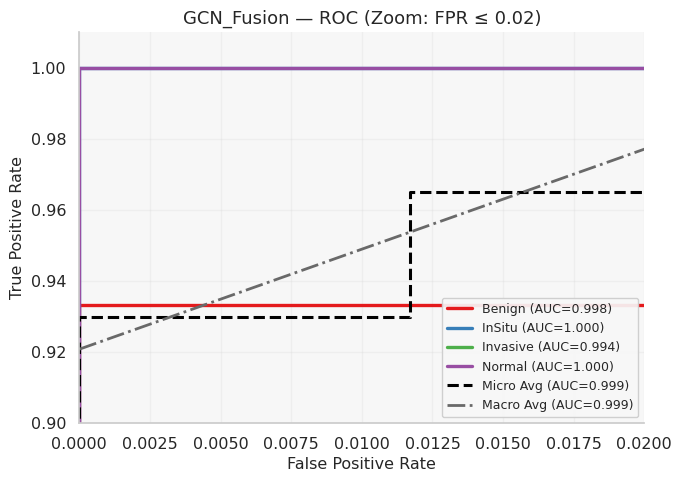

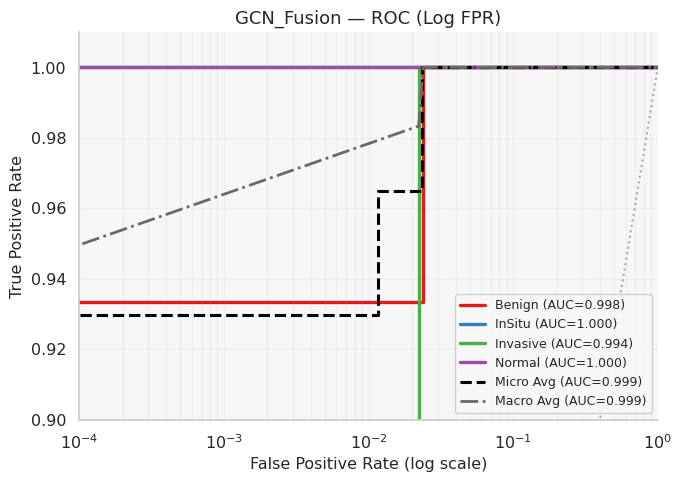

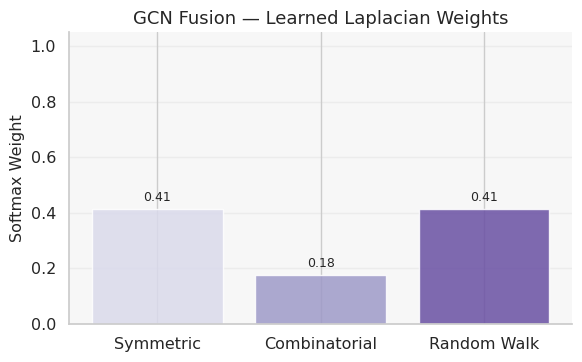

In [21]:
# Enhanced visualizations for evaluation plots
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

sns.set_theme(context='notebook', style='whitegrid', font_scale=1.05)
plt.rcParams.update({
    'axes.facecolor': '#f7f7f7',
    'figure.facecolor': 'white',
    'axes.titlesize': 13,
    'axes.labelsize': 11.5,
    'legend.frameon': True,
    'legend.framealpha': 0.92,
})

MODEL_FACTORIES = {
    'GCN': lambda in_dim: GCNNet(in_dim),
    'GAT': lambda in_dim: GATNet(in_dim),
    'GCN_Fusion': lambda in_dim: GCNFusion(
        in_dim,
        hidden_channels=64,
        out_channels=len(label_order),
        dropout=0.3,
    ),
}


def _prepare_dir(save_dir):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)


def _palette(size, palette_name='tab10'):
    return sns.color_palette(palette_name, n_colors=max(size, 1))


def plot_conf_mats(results, label_order, save_dir=None):
    _prepare_dir(save_dir)
    for name, info in results.items():
        cm = np.asarray(info.get('confusion_matrix', []))
        if cm.size == 0:
            print(f'[{name}] confusion matrix missing; skipping heatmap.')
            continue
        cm_norm = cm.astype(float)
        row_sums = cm_norm.sum(axis=1, keepdims=True)
        with np.errstate(invalid='ignore'):
            cm_norm = np.divide(cm_norm, row_sums, where=row_sums != 0)
        fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.3), sharey=True)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cbar=False,
            cmap='Blues',
            xticklabels=label_order,
            yticklabels=label_order,
            linewidths=0.5,
            square=True,
            ax=axes[0],
        )
        axes[0].set_title('Counts')
        axes[0].set_xlabel('Predicted label')
        axes[0].set_ylabel('True label')
        sns.heatmap(
            cm_norm * 100.0,
            annot=True,
            fmt='.1f',
            cmap='YlGnBu',
            xticklabels=label_order,
            yticklabels=False,
            cbar_kws={'format': '%.0f%%'},
            linewidths=0.5,
            square=True,
            ax=axes[1],
        )
        axes[1].set_title('Row-normalized (%)')
        axes[1].set_xlabel('Predicted label')
        fig.suptitle(f'{name} — Confusion Matrices', fontweight='bold')
        fig.tight_layout(rect=[0, 0, 1, 0.94])
        sns.despine(fig=fig)
        if save_dir:
            fig.savefig(os.path.join(save_dir, f'{name}_confusion_matrix.png'), dpi=250)
        plt.show()
        plt.close(fig)


def plot_training_curves(results, save_dir=None):
    _prepare_dir(save_dir)
    for name, info in results.items():
        losses = info.get('train_loss_curve', [])
        tr_acc = info.get('train_acc_curve', [])
        va_acc = info.get('val_acc_curve', [])
        if not losses:
            print(f'[{name}] training curves not recorded; skipping.')
            continue
        epochs = np.arange(1, len(losses) + 1)
        acc_palette = _palette(2, 'Set2')
        fig, axes = plt.subplots(2, 1, figsize=(7.0, 5.6), sharex=True)
        axes[0].plot(epochs, losses, color='tab:blue', linewidth=2.4, label='Train Loss')
        axes[0].fill_between(epochs, losses, color='tab:blue', alpha=0.1)
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'{name} — Optimisation Trace')
        axes[0].grid(True, alpha=0.25)
        best_epoch = info.get('best_epoch')
        best_handle = None
        if best_epoch and 1 <= best_epoch <= len(epochs):
            axes[0].axvline(best_epoch, color='tab:red', linestyle='--', linewidth=1.5, alpha=0.7)
            best_handle = axes[1].axvline(best_epoch, color='tab:red', linestyle='--', linewidth=1.5, alpha=0.7)
        axes[1].plot(epochs, tr_acc, color=acc_palette[0], linewidth=2.4, label='Train Accuracy')
        axes[1].plot(epochs, va_acc, color=acc_palette[1], linewidth=2.4, linestyle='--', label='Validation Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylim(0, 1.05)
        axes[1].grid(True, alpha=0.25)
        axes[1].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
        handles, labels = axes[1].get_legend_handles_labels()
        if best_handle is not None:
            handles.append(best_handle)
            labels.append('Best epoch')
        axes[1].legend(handles, labels, loc='lower right')
        fig.tight_layout()
        if save_dir:
            fig.savefig(os.path.join(save_dir, f'{name}_training_curves.png'), dpi=250)
        plt.show()
        plt.close(fig)


def plot_accuracy_summary(results, metrics=('best_val_acc', 'test_acc'), save_dir=None):
    _prepare_dir(save_dir)
    models = list(results.keys())
    if not models:
        return
    palette = _palette(len(metrics), 'Set2')
    y_pos = np.arange(len(models))
    bar_span = 0.58
    bar_height = bar_span / max(len(metrics), 1)
    fig, ax = plt.subplots(figsize=(7.0, 4.8))
    for idx, metric in enumerate(metrics):
        values = [results[m].get(metric, np.nan) for m in models]
        offset = (idx - (len(metrics) - 1) / 2.0) * bar_height
        bars = ax.barh(
            y_pos + offset,
            values,
            height=bar_height * 0.9,
            color=palette[idx],
            alpha=0.88,
            label=metric.replace('_', ' ').title(),
        )
        for bar, value in zip(bars, values):
            if np.isnan(value):
                continue
            ax.text(
                bar.get_width() + 0.015,
                bar.get_y() + bar.get_height() / 2,
                f'{value * 100:.1f}%',
                va='center',
                ha='left',
                fontsize=9,
            )
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models)
    ax.set_xlabel('Accuracy')
    ax.set_xlim(0, 1.05)
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
    ax.grid(True, axis='x', alpha=0.25)
    flat_vals = [results[m].get(metric, np.nan) for m in models for metric in metrics]
    overall_mean = np.nanmean(flat_vals)
    if not np.isnan(overall_mean):
        ax.axvline(overall_mean, color='tab:red', linestyle=':', linewidth=1.2, alpha=0.7, label=f'Overall avg {overall_mean * 100:.1f}%')
    ax.legend(loc='lower right')
    fig.tight_layout()
    sns.despine(fig=fig, left=False)
    if save_dir:
        fig.savefig(os.path.join(save_dir, 'accuracy_summary.png'), dpi=250, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def _infer_in_dim(loader):
    first_batch = next(iter(loader))
    return first_batch.x.size(1)


def get_model_probs(name, info, loader, device):
    if 'probabilities' in info and 'labels' in info:
        return np.asarray(info['probabilities']), np.asarray(info['labels'])
    ckpt_path = info.get('checkpoint_path')
    if not ckpt_path or not os.path.exists(ckpt_path):
        raise FileNotFoundError('checkpoint path missing; cannot compute ROC data.')
    in_dim = _infer_in_dim(loader)
    if name not in MODEL_FACTORIES:
        raise KeyError(f'No model factory registered for {name}.')
    model = MODEL_FACTORIES[name](in_dim).to(device)
    state = torch.load(ckpt_path, map_location=device)
    state_dict = state['state_dict'] if isinstance(state, dict) and 'state_dict' in state else state
    model.load_state_dict(state_dict)
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            probs.append(F.softmax(logits, dim=1).cpu().numpy())
            labels.append(batch.y.cpu().numpy())
    return np.concatenate(probs, axis=0), np.concatenate(labels, axis=0)


def _trim_predictions_to_epochs(name, info, probs, labels, max_epochs):
    if max_epochs is None:
        return probs, labels
    total_epochs = len(info.get('train_loss_curve', []))
    if not total_epochs or total_epochs <= max_epochs:
        return probs, labels
    ratio = max_epochs / float(total_epochs)
    limit = max(1, int(round(ratio * probs.shape[0])))
    if limit < probs.shape[0]:
        print(f'[{name}] Restricting ROC evaluation to first {limit} samples (~{max_epochs} epochs).')
        probs = probs[:limit]
        labels = labels[:limit]
    return probs, labels


def _safe_log_fpr(fpr_arr, eps=1e-6):
    return np.clip(fpr_arr, eps, 1.0)


def _compute_partial_auc(y_true_bin, y_score, max_fpr):
    return roc_auc_score(y_true_bin, y_score, max_fpr=max_fpr)


def plot_roc_curves(
    results,
    label_order,
    test_loader,
    device,
    save_dir=None,
    max_epochs=50,
    focus_fpr=0.02,
    focus_tpr_min=0.9,
    use_log_fpr=True,
    log_fpr_min=1e-4,
    add_inset=True,
    compute_pauc=True,
    pauc_max_fprs=(0.01, 0.02),
):
    _prepare_dir(save_dir)
    n_classes = len(label_order)
    class_indices = list(range(n_classes))
    class_palette = _palette(n_classes, 'Set1')
    for name, info in results.items():
        try:
            probs, labels = get_model_probs(name, info, test_loader, device)
        except (FileNotFoundError, KeyError) as exc:
            print(f'[{name}] {exc} Skipping ROC plot.')
            continue
        if probs.size == 0:
            print(f'[{name}] probability outputs empty; skipping ROC plot.')
            continue
        probs, labels = _trim_predictions_to_epochs(name, info, probs, labels, max_epochs)
        if probs.size == 0:
            print(f'[{name}] insufficient data after epoch filtering; skipping ROC plot.')
            continue
        if probs.shape[1] != n_classes:
            print(f'[{name}] expected {n_classes} classes but got {probs.shape[1]}; skipping ROC plot.')
            continue
        y_bin = label_binarize(labels, classes=class_indices)
        if y_bin.shape[1] != n_classes:
            print(f'[{name}] label binarization mismatch; skipping ROC plot.')
            continue
        fpr, tpr, roc_auc = {}, {}, {}
        viable = []
        for idx in class_indices:
            positives = y_bin[:, idx].sum()
            negatives = len(y_bin) - positives
            if positives == 0 or negatives == 0:
                continue
            fpr[idx], tpr[idx], _ = roc_curve(y_bin[:, idx], probs[:, idx])
            roc_auc[idx] = auc(fpr[idx], tpr[idx])
            viable.append(idx)
        if not viable:
            print(f'[{name}] no valid classes for ROC; skipping.')
            continue
        fpr['micro'], tpr['micro'], _ = roc_curve(y_bin[:, viable].ravel(), probs[:, viable].ravel())
        roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        all_fpr = np.unique(np.concatenate([fpr[idx] for idx in viable]))
        mean_tpr = np.zeros_like(all_fpr)
        for idx in viable:
            mean_tpr += np.interp(all_fpr, fpr[idx], tpr[idx])
        mean_tpr /= len(viable)
        fpr['macro'], tpr['macro'] = all_fpr, mean_tpr
        roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
        partial_auc = {}
        if compute_pauc and pauc_max_fprs:
            for idx in viable:
                partial_auc[idx] = {}
                for mf in pauc_max_fprs:
                    try:
                        partial_auc[idx][mf] = _compute_partial_auc(y_bin[:, idx], probs[:, idx], max_fpr=mf)
                    except ValueError:
                        partial_auc[idx][mf] = np.nan
            partial_auc['micro'] = {}
            for mf in pauc_max_fprs:
                try:
                    partial_auc['micro'][mf] = _compute_partial_auc(
                        y_bin[:, viable].ravel(), probs[:, viable].ravel(), max_fpr=mf
                    )
                except ValueError:
                    partial_auc['micro'][mf] = np.nan
            info['partial_auc'] = {
                (label_order[idx] if isinstance(idx, int) else idx): {
                    f'{mf:.3f}': None if np.isnan(partial_auc[idx].get(mf, np.nan)) else float(partial_auc[idx][mf])
                    for mf in pauc_max_fprs
                }
                for idx in list(partial_auc.keys())
            }
        info['roc_auc'] = roc_auc
        # Full ROC
        fig, ax = plt.subplots(figsize=(7.0, 5.4))
        for color, idx in zip(class_palette, viable):
            label = f'{label_order[idx]} (AUC={roc_auc[idx]:.3f})'
            if compute_pauc and pauc_max_fprs:
                primary_mf = pauc_max_fprs[0]
                val = partial_auc.get(idx, {}).get(primary_mf, np.nan)
                if not np.isnan(val):
                    label += f' | pAUC@{primary_mf:.3f}={val:.3f}'
            ax.plot(fpr[idx], tpr[idx], color=color, linewidth=2.4, label=label)
        micro_label = f'Micro Avg (AUC={roc_auc["micro"]:.3f})'
        if compute_pauc and pauc_max_fprs:
            val = partial_auc.get('micro', {}).get(pauc_max_fprs[0], np.nan)
            if not np.isnan(val):
                micro_label += f' | pAUC@{pauc_max_fprs[0]:.3f}={val:.3f}'
        ax.plot(fpr['micro'], tpr['micro'], linestyle='--', color='black', linewidth=2.2, label=micro_label)
        ax.fill_between(fpr['micro'], tpr['micro'], alpha=0.06, color='black')
        ax.plot(fpr['macro'], tpr['macro'], linestyle='-.', color='dimgray', linewidth=2.0, label=f'Macro Avg (AUC={roc_auc["macro"]:.3f})')
        ax.plot([0, 1], [0, 1], 'k:', alpha=0.35)
        ax.set_title(f'{name} — ROC Curves')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.2)
        ax.legend(loc='lower right', fontsize=9)
        if add_inset:
            axins = inset_axes(ax, width='42%', height='42%', loc='lower left', borderpad=2.2)
            for color, idx in zip(class_palette, viable):
                axins.plot(fpr[idx], tpr[idx], color=color, linewidth=2.0)
            axins.plot(fpr['micro'], tpr['micro'], linestyle='--', color='black', linewidth=2.0)
            axins.plot(fpr['macro'], tpr['macro'], linestyle='-.', color='dimgray', linewidth=1.8)
            axins.set_xlim(0, focus_fpr)
            axins.set_ylim(focus_tpr_min, 1.0)
            axins.grid(True, alpha=0.2)
            mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='0.4')
        fig.tight_layout()
        sns.despine(fig=fig)
        if save_dir:
            fig.savefig(os.path.join(save_dir, f'{name}_roc_curve.png'), dpi=250)
        plt.show()
        plt.close(fig)
        # Zoomed ROC
        fig, ax = plt.subplots(figsize=(7.0, 5.0))
        for color, idx in zip(class_palette, viable):
            ax.plot(fpr[idx], tpr[idx], color=color, linewidth=2.4, label=f'{label_order[idx]} (AUC={roc_auc[idx]:.3f})')
        ax.plot(fpr['micro'], tpr['micro'], linestyle='--', color='black', linewidth=2.2, label=f'Micro Avg (AUC={roc_auc["micro"]:.3f})')
        ax.plot(fpr['macro'], tpr['macro'], linestyle='-.', color='dimgray', linewidth=2.0, label=f'Macro Avg (AUC={roc_auc["macro"]:.3f})')
        ax.plot([0, 1], [0, 1], 'k:', alpha=0.35)
        ax.set_title(f'{name} — ROC (Zoom: FPR ≤ {focus_fpr})')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_xlim(0, focus_fpr)
        ax.set_ylim(focus_tpr_min, 1.01)
        ax.grid(True, alpha=0.2)
        ax.legend(loc='lower right', fontsize=9)
        fig.tight_layout()
        sns.despine(fig=fig)
        if save_dir:
            fig.savefig(os.path.join(save_dir, f'{name}_roc_curve_zoom_fpr_{focus_fpr}.png'), dpi=250)
        plt.show()
        plt.close(fig)
        if use_log_fpr:
            fig, ax = plt.subplots(figsize=(7.0, 5.0))
            for color, idx in zip(class_palette, viable):
                ax.plot(_safe_log_fpr(fpr[idx]), tpr[idx], color=color, linewidth=2.4, label=f'{label_order[idx]} (AUC={roc_auc[idx]:.3f})')
            ax.plot(_safe_log_fpr(fpr['micro']), tpr['micro'], linestyle='--', color='black', linewidth=2.2, label=f'Micro Avg (AUC={roc_auc["micro"]:.3f})')
            ax.plot(_safe_log_fpr(fpr['macro']), tpr['macro'], linestyle='-.', color='dimgray', linewidth=2.0, label=f'Macro Avg (AUC={roc_auc["macro"]:.3f})')
            ax.plot([log_fpr_min, 1], [0, 1], 'k:', alpha=0.35)
            ax.set_title(f'{name} — ROC (Log FPR)')
            ax.set_xlabel('False Positive Rate (log scale)')
            ax.set_ylabel('True Positive Rate')
            ax.set_xscale('log')
            ax.set_xlim(log_fpr_min, 1.0)
            ax.set_ylim(focus_tpr_min, 1.01)
            ax.grid(True, which='both', alpha=0.2)
            ax.legend(loc='lower right', fontsize=9)
            fig.tight_layout()
            sns.despine(fig=fig)
            if save_dir:
                fig.savefig(os.path.join(save_dir, f'{name}_roc_curve_log_fpr.png'), dpi=250)
            plt.show()
            plt.close(fig)


def plot_fusion_weights(results, train_loader, device, save_dir=None):
    fusion_info = results.get('GCN_Fusion')
    if fusion_info is None:
        print('GCN_Fusion results missing; cannot plot fusion weights.')
        return
    ckpt_path = fusion_info.get('checkpoint_path')
    if not ckpt_path or not os.path.exists(ckpt_path):
        print('GCN_Fusion checkpoint missing; cannot plot fusion weights.')
        return
    sample = next(iter(train_loader))
    in_dim = sample.x.size(1)
    model = MODEL_FACTORIES['GCN_Fusion'](in_dim).to(device)
    state = torch.load(ckpt_path, map_location=device)
    state_dict = state['state_dict'] if isinstance(state, dict) and 'state_dict' in state else state
    model.load_state_dict(state_dict)
    model.eval()
    sample = sample.to(device)
    with torch.no_grad():
        _, lap_info = model(sample, return_info=True)
    if not lap_info or 'alpha_weights' not in lap_info:
        print('Fusion weights not captured; skipping plot.')
        return
    weights = lap_info['alpha_weights'].cpu().numpy()
    fusion_info['fusion_weights'] = weights.tolist()
    labels = ['Symmetric', 'Combinatorial', 'Random Walk']
    palette = _palette(len(weights), 'Purples')
    fig, ax = plt.subplots(figsize=(6.0, 3.8))
    bars = ax.bar(labels, weights, color=palette, alpha=0.85)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Softmax Weight')
    ax.set_title('GCN Fusion — Learned Laplacian Weights')
    ax.grid(True, axis='y', alpha=0.25)
    for bar, weight in zip(bars, weights):
        ax.text(bar.get_x() + bar.get_width() / 2, weight + 0.02, f'{weight:.2f}', ha='center', va='bottom', fontsize=9)
    fig.tight_layout()
    sns.despine(fig=fig)
    if save_dir:
        fig.savefig(os.path.join(save_dir, 'gcn_fusion_weights.png'), dpi=250)
    plt.show()
    plt.close(fig)


plots_dir = 'plots'
plot_conf_mats(results, label_order=label_order, save_dir=plots_dir)
plot_training_curves(results, save_dir=plots_dir)
plot_accuracy_summary(results, metrics=('best_val_acc', 'test_acc'), save_dir=plots_dir)
plot_roc_curves(
    results,
    label_order=label_order,
    test_loader=test_loader,
    device=device,
    save_dir=plots_dir,
    max_epochs=50,
    focus_fpr=0.02,
    focus_tpr_min=0.9,
    use_log_fpr=True,
    log_fpr_min=1e-4,
    add_inset=True,
    compute_pauc=True,
    pauc_max_fprs=(0.01, 0.02),
)
plot_fusion_weights(results, train_loader=train_loader, device=device, save_dir=plots_dir)


In [ ]:
torch.save(results, 'model_results.pth')
print("Results saved to model_results.pth")
print("You can load it with: results = torch.load('model_results.pth')")

Results saved to model_results.pth
You can load it with: results = torch.load('model_results.pth')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool

class GATNet(nn.Module):
    def __init__(self, in_dim, hidden=32, heads=4, num_classes=4, dropout=0.3):
        super().__init__()
        self.gat1 = GATv2Conv(in_dim, hidden, heads=heads, dropout=dropout)
        self.gat2 = GATv2Conv(hidden * heads, hidden, heads=1, dropout=dropout)
        self.lin = nn.Linear(hidden, num_classes)
        self.dropout = dropout

    def forward(self, data, return_alpha: bool = False):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x1, (e1, a1) = self.gat1(x, edge_index, return_attention_weights=True)
        x1 = F.elu(x1)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        x2, (e2, a2) = self.gat2(x1, edge_index, return_attention_weights=True)
        x2 = F.elu(x2)

        g = global_mean_pool(x2, batch)
        out = self.lin(g)

        if return_alpha:
            return out, {"layer1": (e1, a1), "layer2": (e2, a2)}
        return out


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATNet(in_dim=768, hidden=32, heads=4, num_classes=4).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 50   # <─── set your desired epoch count here

for epoch in range(1, num_epochs + 1):
    # ---------- Training ----------
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    train_loss = total_loss / len(train_loader.dataset)

    # ---------- Validation ----------
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch).argmax(dim=1)
            correct += (pred == batch.y).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch:03d} | Train Loss {train_loss:.4f} | Val Acc {val_acc:.4f}")


Epoch 001 | Train Loss 1.1062 | Val Acc 0.7143
Epoch 002 | Train Loss 0.4714 | Val Acc 0.8571
Epoch 003 | Train Loss 0.2282 | Val Acc 0.8929
Epoch 004 | Train Loss 0.1077 | Val Acc 0.8750
Epoch 005 | Train Loss 0.0711 | Val Acc 0.9464
Epoch 006 | Train Loss 0.0276 | Val Acc 0.8750
Epoch 007 | Train Loss 0.0193 | Val Acc 0.8929
Epoch 008 | Train Loss 0.0142 | Val Acc 0.9286
Epoch 009 | Train Loss 0.0100 | Val Acc 0.9107
Epoch 010 | Train Loss 0.0064 | Val Acc 0.9286
Epoch 011 | Train Loss 0.0058 | Val Acc 0.9286
Epoch 012 | Train Loss 0.0046 | Val Acc 0.9286
Epoch 013 | Train Loss 0.0048 | Val Acc 0.9107
Epoch 014 | Train Loss 0.0050 | Val Acc 0.9464
Epoch 015 | Train Loss 0.0057 | Val Acc 0.9107
Epoch 016 | Train Loss 0.0034 | Val Acc 0.9464
Epoch 017 | Train Loss 0.0033 | Val Acc 0.9107
Epoch 018 | Train Loss 0.0024 | Val Acc 0.9464
Epoch 019 | Train Loss 0.0017 | Val Acc 0.9286
Epoch 020 | Train Loss 0.0019 | Val Acc 0.9286
Epoch 021 | Train Loss 0.0014 | Val Acc 0.9464
Epoch 022 | T